# 今回の取り組み

- homopolymer領域の欠失の補正が甘いので対応します
    - まずは`correct_sequence_error`で完結できないか検討します
    - もしダメそうならhomopolymer用に`correct_repetitive_dels`を復活させます

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

In [3]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
import time

from DAJIN2.core import preprocess, classification, clustering, consensus, report


##### # * 2-cut deletion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "tests/data/knockout/test_barcode25.fq.gz",
    "tests/data/knockout/test_barcode30.fq.gz",
    "tests/data/knockout/design_stx2.fa",
    "single-stx2deletion-extract_qname_of_map_ont/",
    "mm10",
    True,
    30,
)


print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
print(f"validate inputs...")

print(f"check_files")
preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)

TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)

UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
print(f"format inputs...")

SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

print(f"retrieve genomes...")

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)



processing single-stx2deletion-extract_qname_of_map_ont/...
validate inputs...
check_files
format inputs...
retrieve genomes...


In [4]:
flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_control.jsonl").exists()
flag = flag1 and flag2

if not flag:
    # ====================================================================
    # Export fasta files as single-FASTA format
    # ====================================================================
    for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
    # ====================================================================
    # Mapping with mappy
    # ====================================================================
    for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
        name_fasta = path_fasta.stem
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
        )
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
        )
    # ====================================================================
    # MIDSV conversion
    # ====================================================================
    for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    # ====================================================================
    # CSSPLITS Error Correction
    # ====================================================================
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    # ====================================================================
    # Convert any `N` as deletions other than consecutive `N` from both ends
    # ====================================================================
    preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
    preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    # ====================================================================
    # Cashe inputs (control)
    # ====================================================================
    if not IS_CACHE_CONTROL:
        control_hash = Path(CONTROL).read_bytes()
        control_hash = hashlib.sha256(control_hash).hexdigest()
        PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
        PATH_CACHE_HASH.write_text(str(control_hash))


- まずはホモポリマーの領域を調べます

In [5]:
allele = "control"
sequence = FASTA_ALLELES[allele]

In [11]:
idx_homopolymer = sequence.index("AAAAAAAAAAAAAAAAA")

In [13]:
# いったん補正前にリセットします
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)
for allele in FASTA_ALLELES:
    preprocess.call_midsv(TEMPDIR, SAMPLE_NAME, allele)
preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [14]:
from __future__ import annotations

import random
import re
from collections import Counter
from collections import defaultdict
from pathlib import Path

import midsv
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += len(cs.split("|"))
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
    count_indels_removed = dict()
    threshold = coverage * 0.01
    for key, values in count_indels.items():
        values_removed = [v if v >= threshold else 1 for v in values]
        count_indels_removed.update({key: values_removed})
    return count_indels_removed


def _extract_anomaly_loci(indels_sample: dict, indels_control: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key in indels_sample.keys():
        clf = LocalOutlierFactor(novelty=True)
        clf.fit(indels_control[key])
        pred = clf.predict(indels_sample[key])
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
        normal, abnormal = Counter(pred).keys()
        if Counter(pred[:9]).most_common()[0][0] == abnormal:
            normal, abnormal = abnormal, normal
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _calc_distance(indels_sample: dict[str, list[list[int]]], indels_control: dict[str, list[list[int]]]) -> dict[str, list[float]]:
    results = defaultdict(list)
    for mut, value in indels_sample.items():
        for i, val in enumerate(value):
            dist = distance.euclidean(val, indels_control[mut][i])
            results[mut].append(dist)
    return results

def _extract(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
    indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
    # Difference of anomaly within kmers
    x = _split_kmer(indels_sample, kmer = 10)
    y = _split_kmer(indels_control, kmer = 10)
    return _extract_anomaly_loci(x, y)

###########################################################
# postprocesss
###########################################################


def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced

###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract mutation loci
        mutation_loci = _extract(cssplits_sample, cssplits_control)
        # Correct sequence errors
        cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
        cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))


In [15]:
allele = "control"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]

In [16]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
# Difference of anomaly within kmers
x = _split_kmer(indels_sample, kmer = 10)
y = _split_kmer(indels_control, kmer = 10)


In [17]:
allele = "control"
sequence = FASTA_ALLELES[allele]
idx_homopolymer = sequence.index("AAAAAAAAAAAAAAAAA")
print(idx_homopolymer)

398


In [19]:
print(indels_sample["del"][idx_homopolymer])
print(indels_control["del"][idx_homopolymer])

1081
685


In [24]:
print(x["del"][idx_homopolymer])
print(y["del"][idx_homopolymer])
dists = _calc_distance(x, y)
print(dists["del"][idx_homopolymer])

[43, 26, 30, 31, 26, 1081, 988, 838, 699, 548]
[30, 19, 18, 17, 18, 685, 628, 549, 466, 347]
682.0916360724561


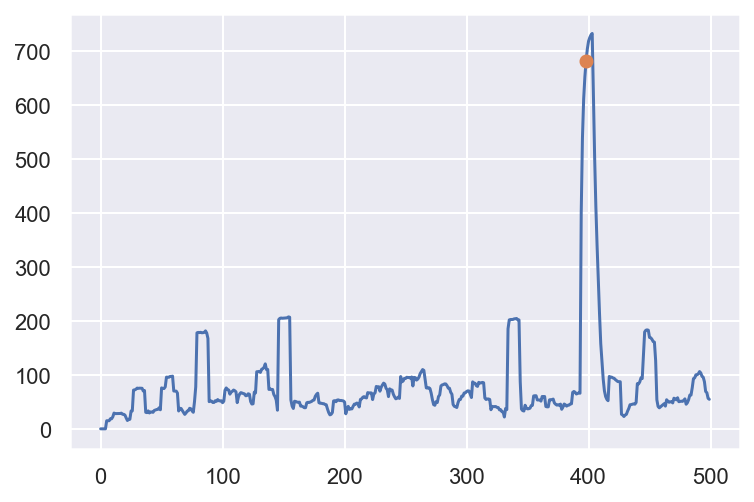

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.plot(dists["del"][:500])
plt.plot(idx_homopolymer, dists["del"][idx_homopolymer], "o")

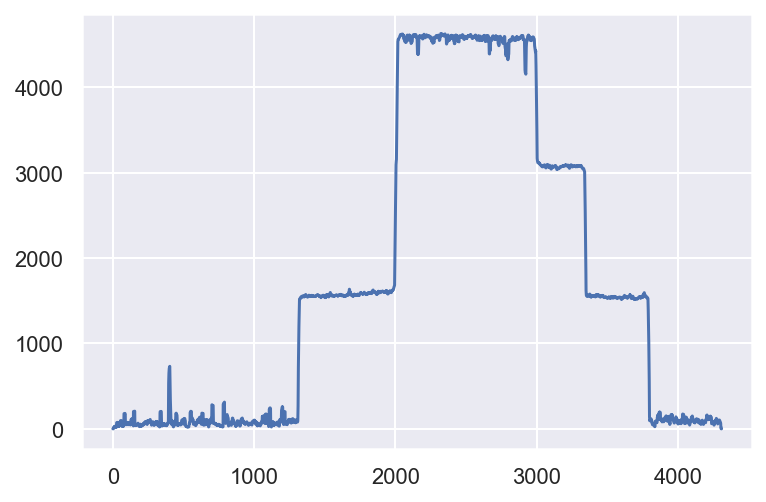

In [31]:
plt.plot(dists["del"])

- うーん、homopolymerでも700くらいの高スコアになっているので、あまり役に立たないかもしれません
- cosine類似度で見てみます

In [32]:
def _calc_distance(indels_sample: dict[str, list[list[int]]], indels_control: dict[str, list[list[int]]]) -> dict[str, list[float]]:
    results = defaultdict(list)
    for mut, value in indels_sample.items():
        for i, val in enumerate(value):
            dist = distance.cosine(val, indels_control[mut][i])
            results[mut].append(dist)
    return results


In [33]:
print(x["del"][idx_homopolymer])
print(y["del"][idx_homopolymer])
dists = _calc_distance(x, y)
print(dists["del"][idx_homopolymer])

[43, 26, 30, 31, 26, 1081, 988, 838, 699, 548]
[30, 19, 18, 17, 18, 685, 628, 549, 466, 347]
0.00019371649131161295


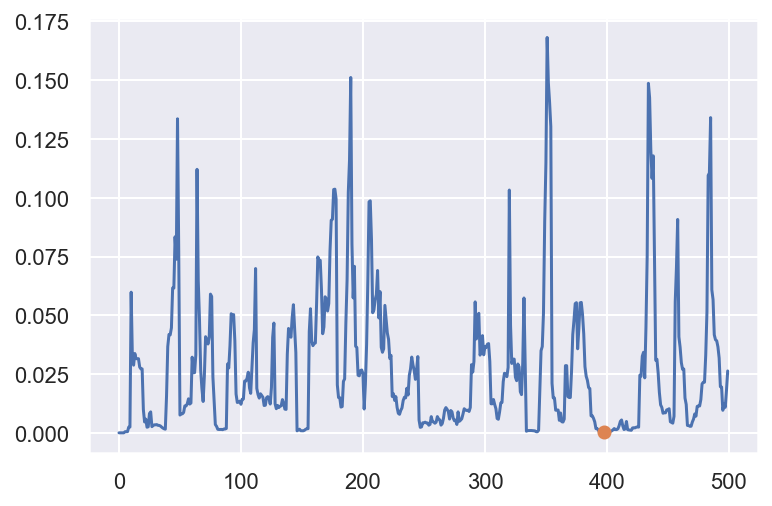

In [34]:
plt.plot(dists["del"][:500])
plt.plot(idx_homopolymer, dists["del"][idx_homopolymer], "o")

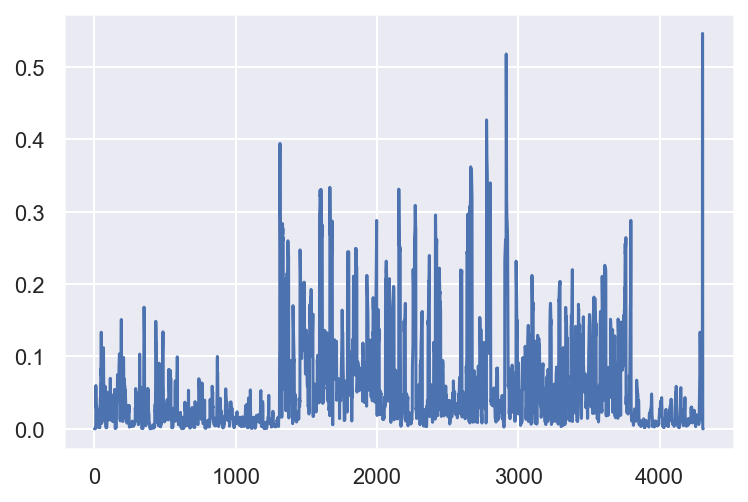

In [35]:
plt.plot(dists["del"])

[1480, 1477, 1475, 1059, 1053, 1047, 1049, 1046, 1023, 1018]
[43, 32, 30, 25, 30, 33, 40, 31, 38, 31]


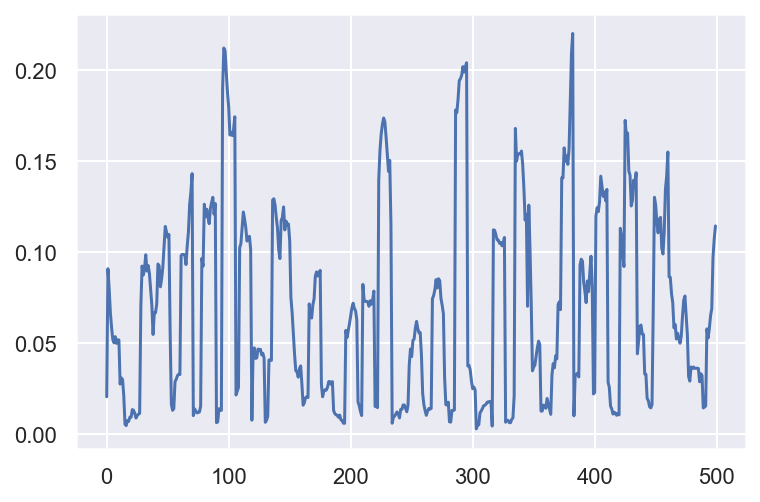

In [37]:
plt.plot(dists["del"][3000:3500])
print(x["del"][3000])
print(y["del"][3000])

- やはりcosine類似度だけではだめですが、`ttest`と組み合わせるともしかして可能性があるかもしれません
    - 3000番目の塩基はcosine類似度こそ高いですが明らか値に乖離があるので、`ttest`では有意差があると期待します

In [40]:
from scipy import stats
_, pvalue = stats.ttest_ind(x["del"][3000], y["del"][3000], equal_var=False)
print(pvalue)
_, pvalue = stats.ttest_ind(x["del"][idx_homopolymer], y["del"][idx_homopolymer], equal_var=False)
print(pvalue)

3.536003397837759e-08
0.37349084910851704


- cosine類似度が高く、かつ`ttest`では有意差がないものがシークエンスエラー

In [47]:
indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
indels_kmer_control = _split_kmer(indels_control, kmer = 10)
key = "del"
cossim = [1 - distance.cosine(x, y) for x, y in zip(indels_kmer_sample[key], indels_kmer_control[key])]
pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[key], indels_kmer_control[key])]

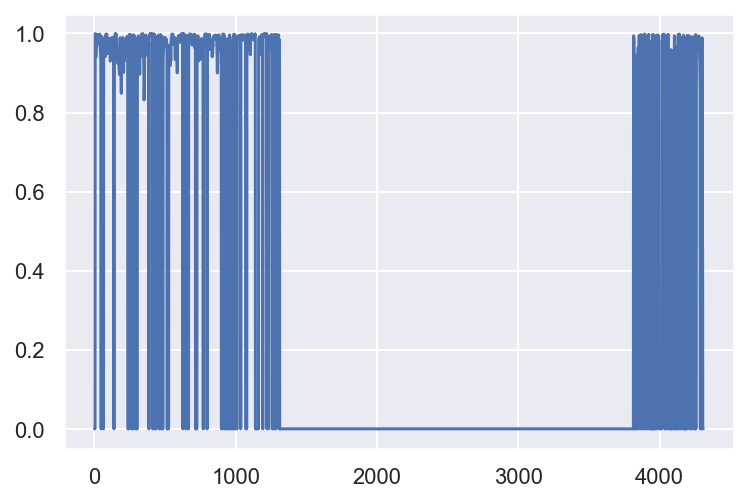

In [50]:
cossim_pval_false = [cossim if pvalue > 0.05 else 0 for cossim, pvalue in zip(cossim, pvalues)]
plt.plot(cossim_pval_false)

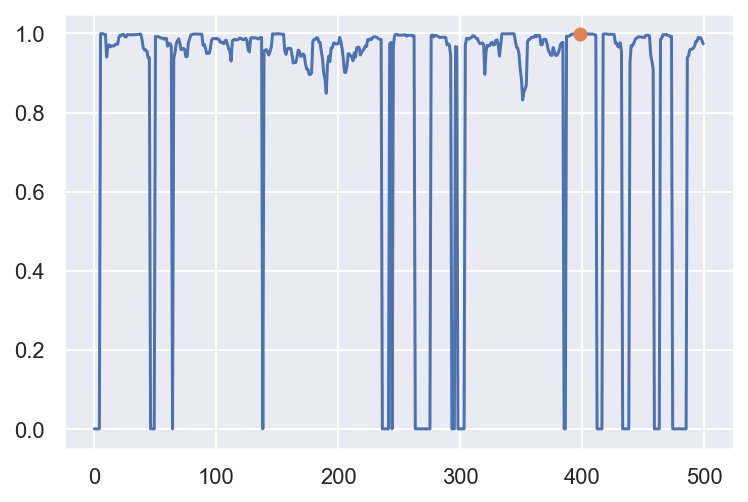

In [51]:
plt.plot(cossim_pval_false[:500])
plt.plot(idx_homopolymer, cossim_pval_false[idx_homopolymer], "o")

In [53]:
idx_homopolymer2 = sequence.index("TTTTACCCCG")

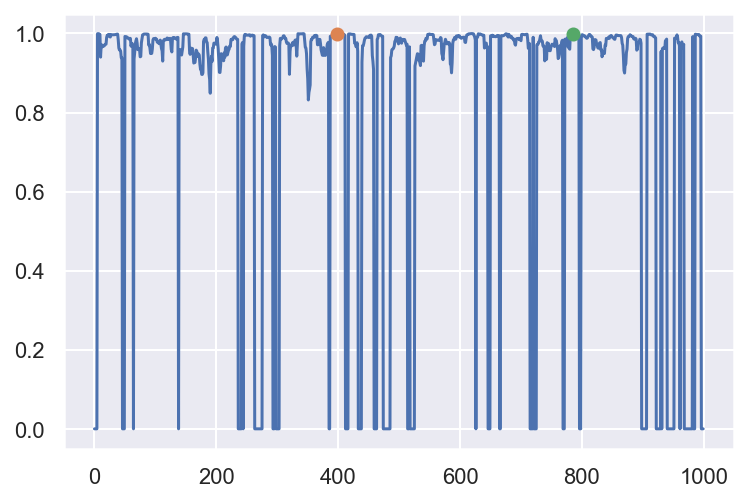

In [54]:
plt.plot(cossim_pval_false[:1000])
plt.plot(idx_homopolymer, cossim_pval_false[idx_homopolymer], "o")
plt.plot(idx_homopolymer2, cossim_pval_false[idx_homopolymer2], "o")

In [63]:
extract_dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x < 0.95}

In [64]:
print(idx_homopolymer in extract_dissimilar_loci)
print(idx_homopolymer2 in extract_dissimilar_loci)

False
False


In [65]:
key = "del"
cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[key], indels_kmer_control[key])]
pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[key], indels_kmer_control[key])]
cossim_pval_false = [cossim if pvalue > 0.05 else 0 for cossim, pvalue in zip(cossim, pvalues)]
extract_dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.95}

In [66]:
print(idx_homopolymer in extract_dissimilar_loci)
print(idx_homopolymer2 in extract_dissimilar_loci)

False
False


In [80]:
from __future__ import annotations

import random
import re
from collections import Counter
from collections import defaultdict
from pathlib import Path

import midsv
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += len(cs.split("|"))
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
    count_indels_removed = dict()
    threshold = coverage * 0.01
    for key, values in count_indels.items():
        values_removed = [v if v >= threshold else 1 for v in values]
        count_indels_removed.update({key: values_removed})
    return count_indels_removed


def _extract_anomaly_loci(indels_sample: dict, indels_control: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key in indels_sample.keys():
        clf = LocalOutlierFactor(novelty=True)
        clf.fit(indels_control[key])
        pred = clf.predict(indels_sample[key])
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
        normal, abnormal = Counter(pred).keys()
        if Counter(pred[:9]).most_common()[0][0] == abnormal:
            normal, abnormal = abnormal, normal
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        cossim_pval_false = [cossim if pvalue > 0.05 else 1 for cossim, pvalue in zip(cossim, pvalues)]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results


def _extract_mutation_loci(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
    indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
    # Difference of anomaly within kmers
    indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
    indels_kmer_control = _split_kmer(indels_control, kmer = 10)
    anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control)
    dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
    mutation_loci = dict()
    for mut in anomaly_loci:
        mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
    return mutation_loci

In [81]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
# Difference of anomaly within kmers
indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
indels_kmer_control = _split_kmer(indels_control, kmer = 10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control)
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
mutation_loci = dict()
for mut in anomaly_loci:
    mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})


In [82]:
print(len(anomaly_loci["del"]))
print(len(dissimilar_loci["del"]))

3072
3096


In [83]:
print(idx_homopolymer in mutation_loci["del"])
print(idx_homopolymer2 in mutation_loci["del"])

False
False


- 無事にホモポリマー領域は省かれているようです
- この段階でテストします

In [84]:
%%bash
rm -rf DAJINResults/single-stx2deletion
rm -rf DAJINResults/.tempdir/single-stx2deletion

time DAJIN2 \
    --name single-stx2deletion \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion to see the report.

real	1m59.057s
user	2m21.928s
sys	1m45.625s


- 🎊🎊🎊かつてないほどうまく動きました…！🎊🎊🎊

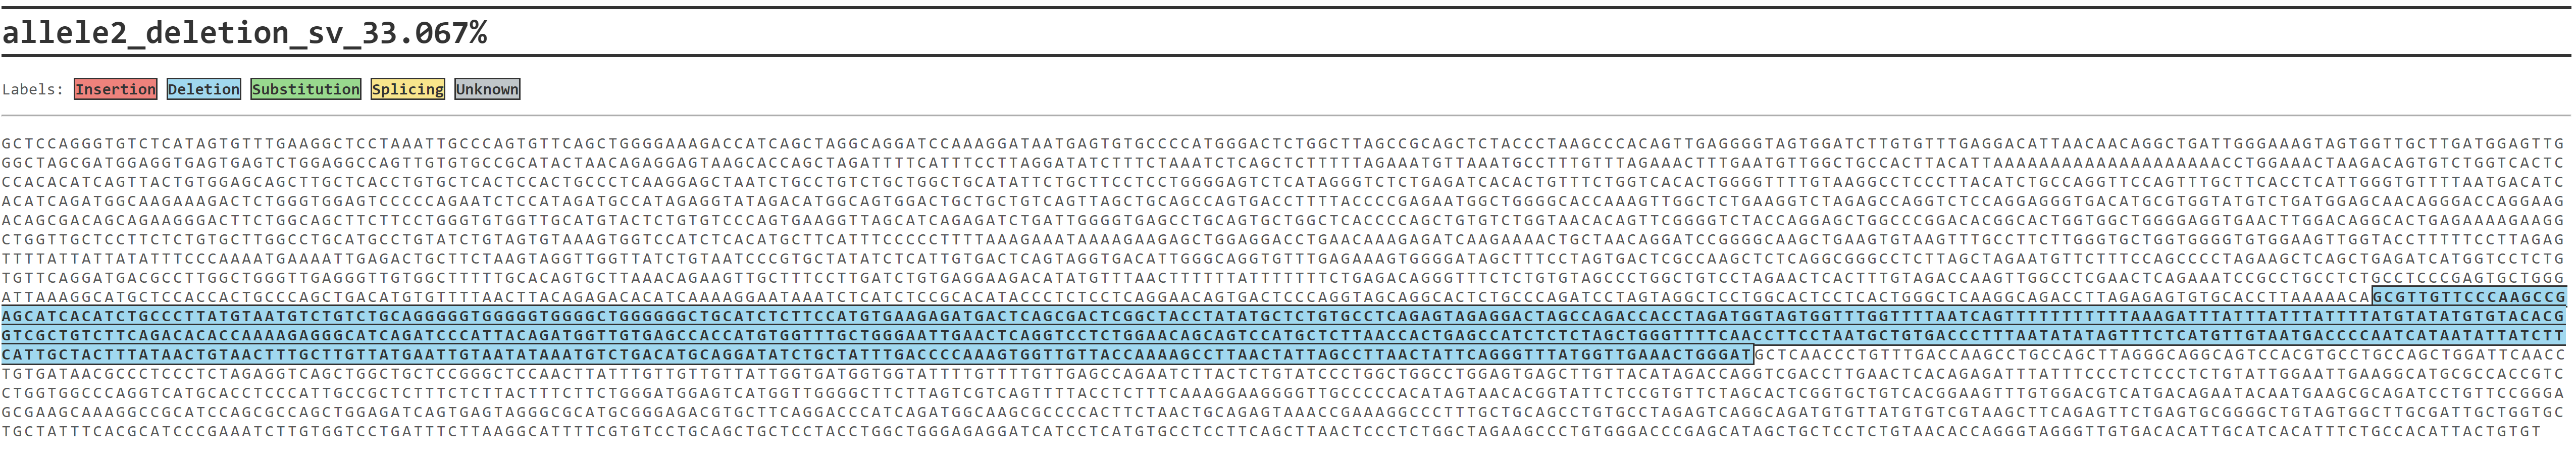

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- ホモポリマー領域の欠失の補正を行いました
  - 想定以上に素晴らしい効果を発揮ました
- Tyr, AyabeTask1で検証します

# 次に取り組むこと

- 現状のアルゴリズムの動作確認をTyr, Stx2, Floxで行う
- mutation_lociをpreprocessで使用したものに変更する

### Lists

+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
+ ✅ ホモポリマー領域の欠失について精度が低いので対応する
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする